# Read 3-D WRF output process data files and make some plots of vertical profiles.<br>
Read FINO 1 data record (from Pat Hawbecker) and plot some vertical profile comparisons<br>
Calculate some statistics for model evaluation.

### File Path information

In [23]:
################################################################################
##Path to WRF output files
WRF_path = '/p/lscratchh/lassman1/a2e-mmc/pdata/FINO/'


## WRF pdata files, each containing 1 hour of output
# Control simulation
WRF_fncontrol = [ WRF_path + 'setup2-controld06_3D_hr1.nc',\
                  WRF_path + 'setup2-controld06_3D_hr2.nc',\
                  WRF_path + 'setup2-controld06_3D_hr3.nc',\
                  WRF_path + 'setup2-controld06_3D_hr4.nc']

# Cell Perturbation Method (CPM) Simulation
WRF_fncpm     = [ WRF_path + 'setup2-cpmd06_3D_hr1.nc',\
                  WRF_path + 'setup2-cpmd06_3D_hr2.nc',\
                  WRF_path + 'setup2-cpmd06_3D_hr3.nc',\
                  WRF_path + 'setup2-cpmd06_3D_hr4.nc']




In [24]:
################################################################################
# FINO1 data path
FINO_fpath = '../Data/FINO/FINO1_obs.nc'



In [25]:
################################################################################
# File path to save figures
save_fig_dir = '/g/g12/lassman1/mmc/Figures/FINO/microscale_v_prof_analysis/'

### Import python modules. <br>
MMCtools is pointed to using os to find the path, but this can also be installed with conda.

In [26]:
# Import modules

import numpy as np
from netCDF4 import Dataset as nc
import xarray as xr
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap                                                                                         
import pandas as pd
import datetime
import sys
import os

import geopandas as gpd
import cartopy as ctp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ssl

import wrf as wrfpy
import glob


module_path = os.path.join(os.environ['HOME'],'code/Python/a2e-mmc/')
#module_path = os.path.join(os.environ['HOME'],'mmc/mmc_github_clones/')                                                          
if module_path not in sys.path:
    sys.path.append(module_path)


from matplotlib.colors import Normalize, LinearSegmentedColormap

from taylorDiagram import TaylorDiagram
from statsmodels.nonparametric.smoothers_lowess import lowess

from mmctools.helper_functions import theta_to_T, lowess_mean
from mmctools.wrf.utils import Tower, tsout_seriesReader, write_tslist_file


### Constants, lat/lon coordinates of FINO 1 tower, etc...

In [27]:
FINO_1_lat = 54.0148
FINO_1_lon = 6.587638

TH0 = 300



### Load data

In [28]:
# WRF output for both simulations, formatted the same
ds_control = xr.open_mfdataset( WRF_fncontrol, concat_dim = 'datetime' )
ds_cpm = xr.open_mfdataset( WRF_fncpm, concat_dim = 'datetime' )

In [29]:
# Display coords, dims, and variables (comment this out if you don't care)
print("******************************************************************")
print("ds_control, coords:", ds_control.coords)
print("******************************************************************")
print("ds_control, dims:", ds_control.dims)
print("******************************************************************")
print("ds_control, Variables:", ds_control.variables)

# Important variables and coords used in this analysis:
#      Vertical coordinate (z) is 4-D due to WRF's preferred vertical coordinate [m]
#      Windspeed [wspd] [m/s]
#      Potential Temperature [theta] [k]
#

******************************************************************
ds_control, coords: Coordinates:
    y         (ny) float64 dask.array<chunksize=(600,), meta=np.ndarray>
    lat       (ny, nx) float32 dask.array<chunksize=(600, 600), meta=np.ndarray>
    zsurface  (ny, nx) float32 dask.array<chunksize=(600, 600), meta=np.ndarray>
    x         (nx) float64 dask.array<chunksize=(600,), meta=np.ndarray>
    lon       (ny, nx) float32 dask.array<chunksize=(600, 600), meta=np.ndarray>
  * datetime  (datetime) datetime64[ns] 2010-05-16T01:01:00 ... 2010-05-16T04...
    z         (datetime, nz, ny, nx) float32 dask.array<chunksize=(54, 32, 600, 600), meta=np.ndarray>
******************************************************************
ds_control, dims: Frozen(SortedKeysDict({'ny': 600, 'nx': 600, 'datetime': 207, 'nz': 32}))
******************************************************************
ds_control, Variables: Frozen({'y': <xarray.Variable (ny: 600)>
dask.array<where, shape=(600,), dtype

In [30]:
# FINO 1 processed obs

ds_obs = xr.open_dataset( FINO_fpath )



In [31]:
# Display dims, coords, and variables (comment this out if you don't care)
print("******************************************************************")
print("ds_obs, coords:", ds_obs.coords)
print("******************************************************************")
print("ds_obs, dims:", ds_obs.dims)
print("******************************************************************")
print("ds_obs, Variables:", ds_obs.variables)
# Important variables and coords used in this analysis:
#      Vertical coordinate (z) is different depending on variable of interest. For example, use 'spd_levels' for windspeed heights
#      Windspeed [wspd] [m/s]
#      Temperature [temp] [k]
#

******************************************************************
ds_obs, coords: Coordinates:
  * anm_levels  (anm_levels) float64 40.0 60.0 80.0
  * datetime    (datetime) datetime64[ns] 2010-01-01T00:10:00 ... 2011-01-01
  * rh_levels   (rh_levels) float64 30.0 50.0
  * tmp_levels  (tmp_levels) float64 30.0 40.0 50.0 70.0 100.0
  * dir_levels  (dir_levels) float64 33.0 40.0 50.0 60.0 70.0 80.0 90.0
  * spd_levels  (spd_levels) float64 33.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0
  * sst_levels  (sst_levels) float64 0.0
  * pcp_levels  (pcp_levels) float64 90.0
  * rad_levels  (rad_levels) float64 30.0
******************************************************************
ds_obs, dims: Frozen(SortedKeysDict({'spd_levels': 8, 'datetime': 61032, 'dir_levels': 7, 'tmp_levels': 5, 'sst_levels': 1, 'pcp_levels': 1, 'rh_levels': 2, 'rad_levels': 1, 'anm_levels': 3}))
******************************************************************
ds_obs, Variables: Frozen({'wspd': <xarray.Variable (spd_levels:

### Some brief calculations

In [32]:
# Use z1D to determine a single 1-dimensional z coordinate
ds_control['z1D'] =  ds_control.z.mean(dim = ("nx", "ny", "datetime") )
ds_cpm['z1D'] =  ds_cpm.z.mean(dim = ("nx", "ny", "datetime") )

# Use "resample" function take 10 minute average of WRF output to align w/ FINO tower obs
ds_10min_control = ds_control.resample(datetime="10MIN" ).reduce(np.mean)
ds_10min_cpm = ds_cpm.resample(datetime="10MIN" ).reduce(np.mean)


/g/g12/lassman1/anaconda3/envs/wildfire/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/g/g12/lassman1/anaconda3/envs/wildfire/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


In [33]:
# Find x and y index of FINO1 tower in model domain using Haversine function
# (https://en.wikipedia.org/wiki/Haversine_formula)

from Vertical_Profile_Functions import haversine
distances = haversine( ds_10min_cpm.lon, ds_10min_cpm.lat, FINO_1_lon, FINO_1_lat )
i_dmin, j_dmin = np.where( distances == distances.min() )


## Plotting

### Vertical profile, comparing to data

In [35]:
# Import plotting functions
from Vertical_Profile_Functions import plot_singletime_v_prof_h_avg, plot_timecolor_v_prof_h_avg, \
                                       plot_timecolor_v_prof_diff_h_avg, plan_view_pcolor, plot_spacecolor_v_prof_h_avg, \
                                       plot_spacecolor_v_prof_diff_h_avg, bulk_shear, integrated_shear

None
no save string provided
None
no save string provided


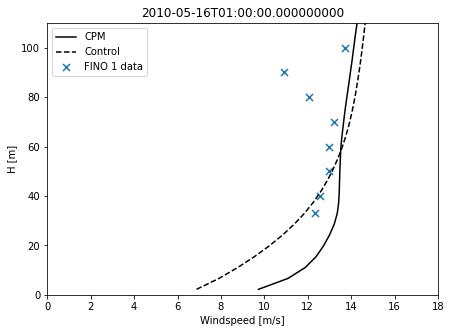

In [36]:
#Example vertical profile plot



tt = ds_10min_cpm.datetime[0]

f, ax = plot_singletime_v_prof_h_avg( ds_10min_cpm, ds_obs, tt, i_dmin, j_dmin , wrf_lab ='CPM' )

f, ax = plot_singletime_v_prof_h_avg(ds_10min_control, ds_obs, tt, i_dmin, j_dmin, plot_objs = (f,ax), wrf_lab ='Control' )

plt.savefig( save_fig_dir + 'vprof_model_obs_example.png', dpi = 300)

2010-05-16_01:00:00
None
no save string provided
None
no save string provided
2010-05-16_01:10:00
None
no save string provided
None
no save string provided
2010-05-16_01:20:00
None
no save string provided
None
no save string provided
2010-05-16_01:30:00
None
no save string provided
None
no save string provided
2010-05-16_01:40:00
None
no save string provided
None
no save string provided
2010-05-16_01:50:00
None
no save string provided
None
no save string provided
2010-05-16_02:00:00
None
no save string provided
None
no save string provided
2010-05-16_02:10:00
None
no save string provided
None
no save string provided
2010-05-16_02:20:00


/g/g12/lassman1/anaconda3/envs/wildfire/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


None
no save string provided
None
no save string provided
2010-05-16_02:30:00
None
no save string provided
None
no save string provided
2010-05-16_02:40:00
None
no save string provided
None
no save string provided
2010-05-16_02:50:00
None
no save string provided
None
no save string provided
2010-05-16_03:00:00
None
no save string provided
None
no save string provided
2010-05-16_03:10:00
None
no save string provided
None
no save string provided
2010-05-16_03:20:00
None
no save string provided
None
no save string provided
2010-05-16_03:30:00
None
no save string provided
None
no save string provided
2010-05-16_03:40:00
None
no save string provided
None
no save string provided
2010-05-16_03:50:00
None
no save string provided
None
no save string provided
2010-05-16_04:00:00


/g/g12/lassman1/anaconda3/envs/wildfire/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


None
no save string provided


/g/g12/lassman1/anaconda3/envs/wildfire/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


None
no save string provided
2010-05-16_04:10:00
None
no save string provided
None
no save string provided
2010-05-16_04:20:00


/g/g12/lassman1/mmc/local_code/Vertical_Profile_Functions.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(figsize = (7,5))


None
no save string provided
None
no save string provided
2010-05-16_04:30:00
None
no save string provided
None
no save string provided
2010-05-16_04:40:00
None
no save string provided
None
no save string provided
2010-05-16_04:50:00
None
no save string provided
None
no save string provided


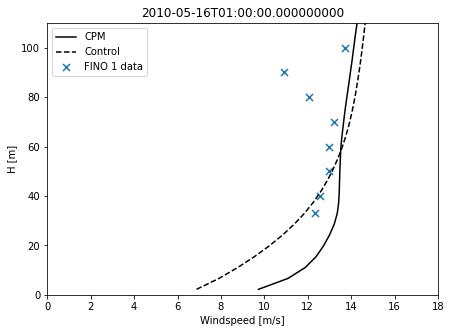

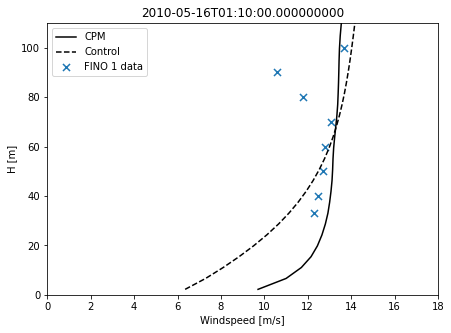

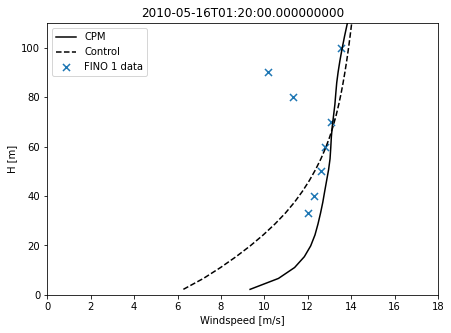

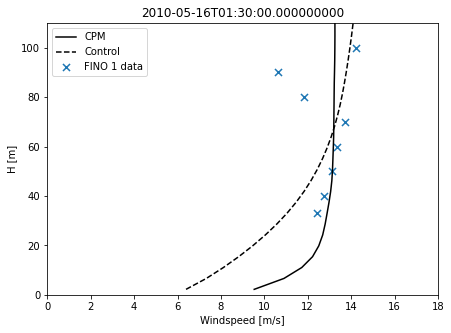

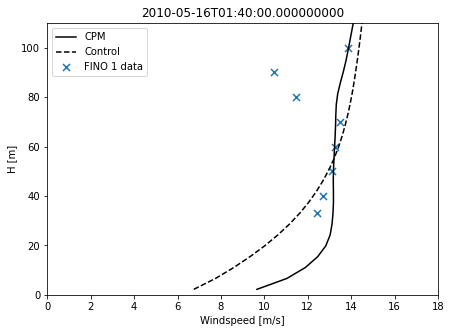

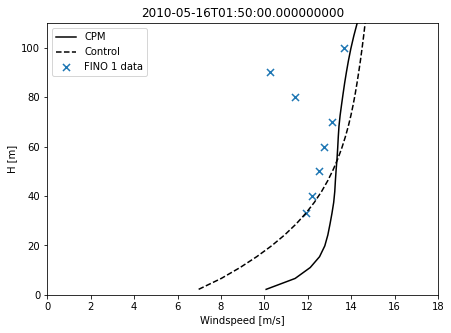

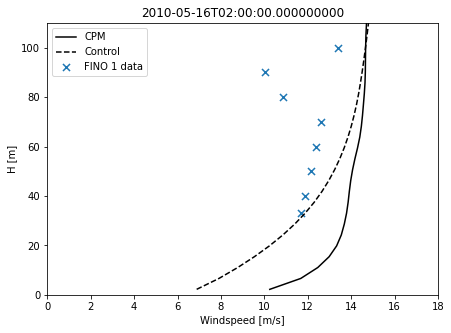

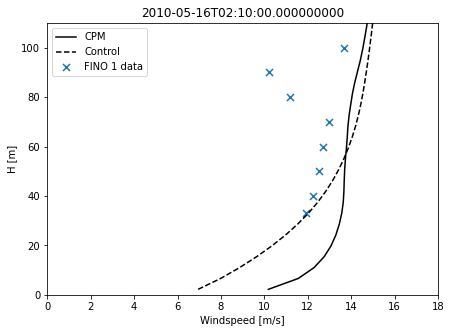

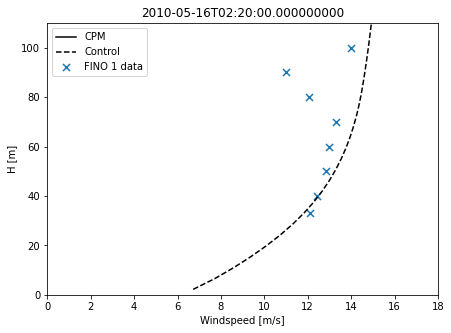

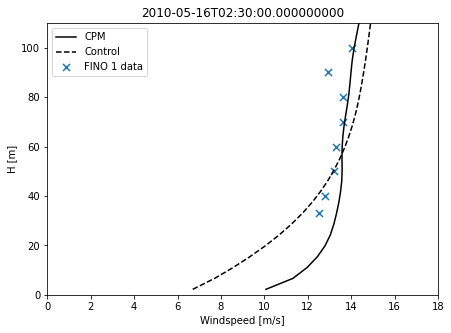

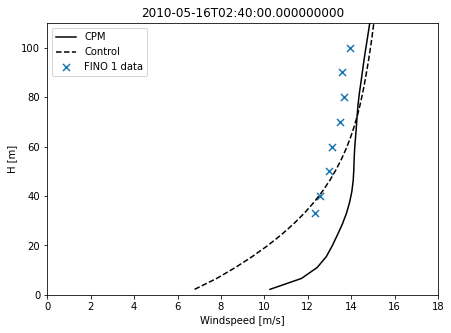

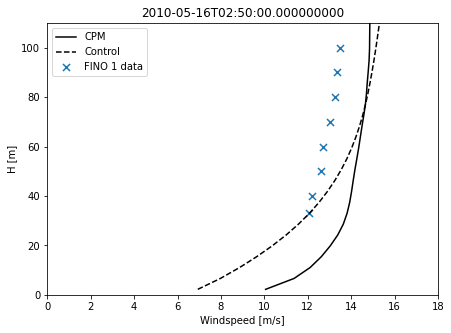

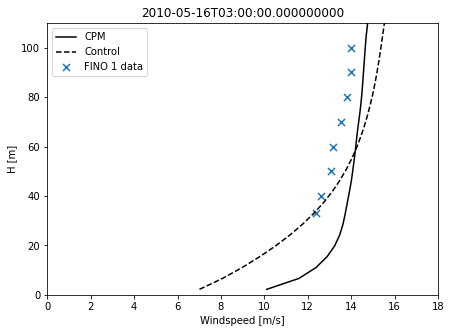

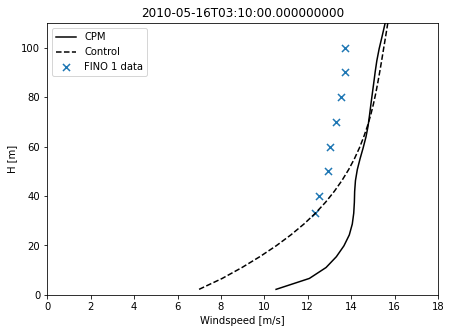

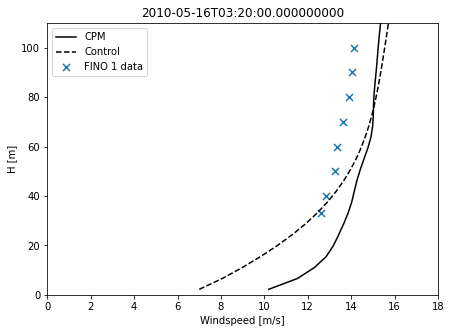

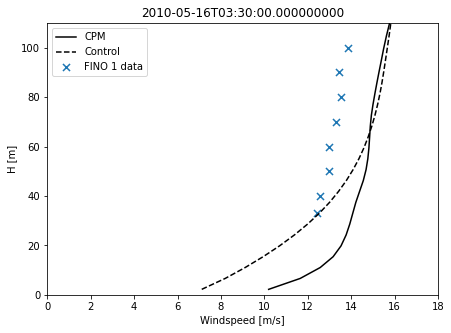

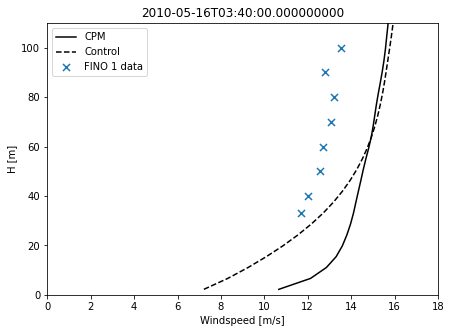

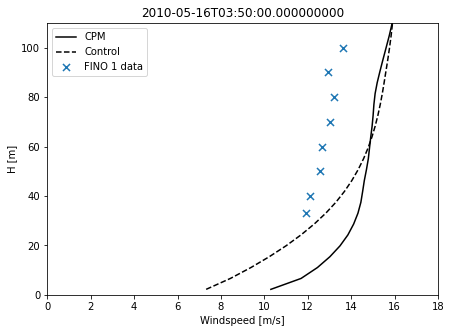

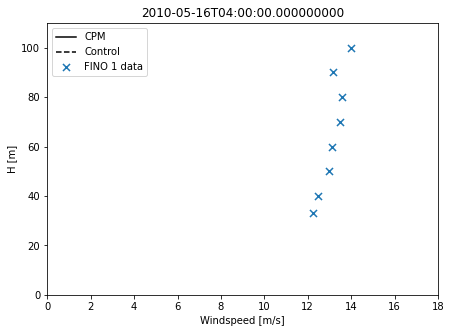

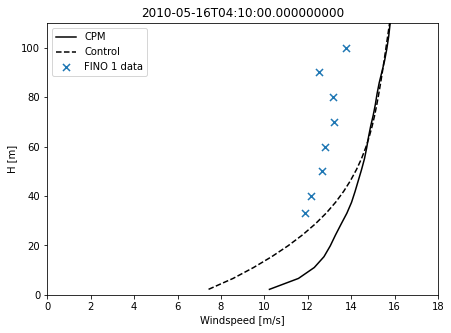

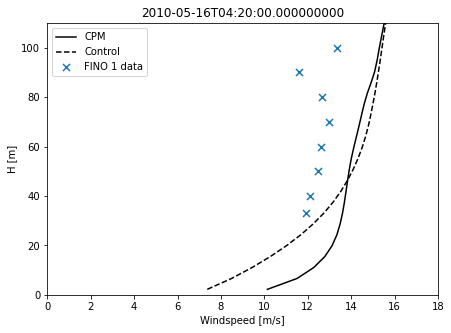

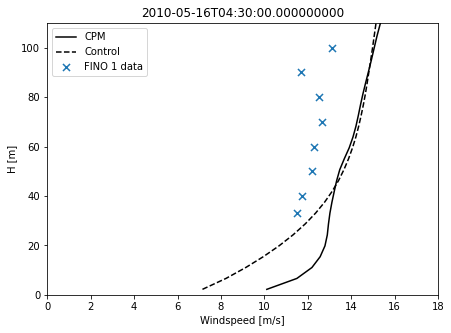

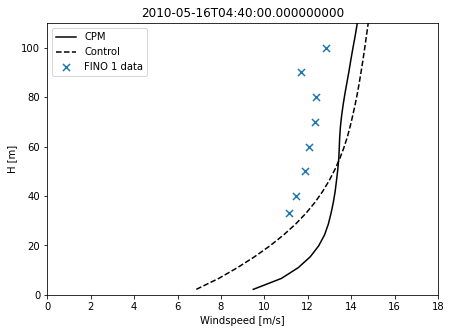

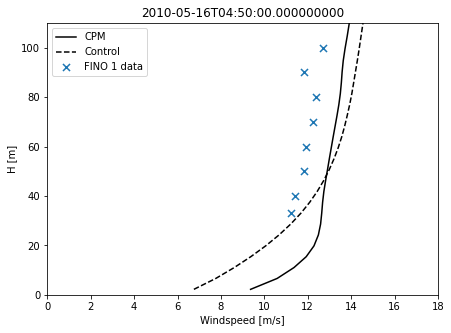

In [37]:
# Plots at every time
import pandas as pd

ct = 0
for tt in ds_10min_cpm.datetime:
    ttstring = pd.to_datetime( tt.values ).strftime( '%Y-%m-%d_%H:%M:%S')
    
    print(ttstring)
    #sys.exit()    
    
    f, ax = plot_singletime_v_prof_h_avg( ds_10min_cpm, ds_obs, tt, i_dmin, j_dmin, wrf_lab = 'CPM' )
    f, ax = plot_singletime_v_prof_h_avg( ds_10min_control, ds_obs, tt, i_dmin, j_dmin, plot_objs = (f,ax), wrf_lab ='Control' )
    
    

    plt.savefig( save_fig_dir + 'vprof_model_obs_' + ttstring + '.png', dpi = 300)
    ct += 10
    

### Vertical profile time-color plots

ds_WRF suppled, doing model profiles
ds_OBS suppled, doing data profiles
Not saving, save_str not provided


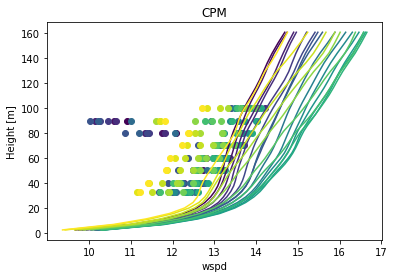

In [38]:


f, ax = plot_timecolor_v_prof_h_avg( vname = 'wspd', \
                                    ds_WRF = ds_10min_cpm, \
                                    ds_OBS = ds_obs, \
                                    i = i_dmin, j = j_dmin, \
                                    wrf_lab = 'CPM')
plt.savefig( save_fig_dir + 'vprof_wspd_timecolor_CPM.png', dpi = 300)
#sys.exit()

ds_WRF suppled, doing model profiles
ds_OBS suppled, doing data profiles
Not saving, save_str not provided


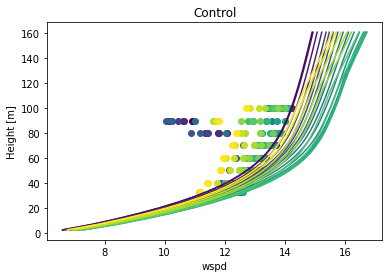

In [39]:


f, ax = plot_timecolor_v_prof_h_avg( vname = 'wspd', \
                                    ds_WRF = ds_10min_control, \
                                    ds_OBS = ds_obs, \
                                    i = i_dmin, j = j_dmin, \
                                    wrf_lab = 'Control')

plt.savefig( save_fig_dir + 'vprof_wspd_timecolor_Control.png', dpi = 300)
#sys.exit()

ds_WRF suppled, doing model profiles
ds_OBS suppled, doing data profiles
Not saving, save_str not provided


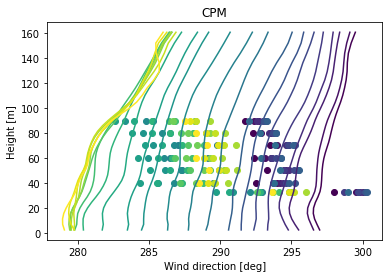

In [56]:
# Wind direction



f, ax = plot_timecolor_v_prof_h_avg( vname = 'wdir', obs_vc = 'dir_levels', \
                                    ds_WRF = ds_10min_cpm, \
                                    ds_OBS = ds_obs, \
                                    i = i_dmin, j = j_dmin, \
                                    wrf_lab = 'CPM')

ax.set_xlabel('Wind direction [deg]')
plt.savefig( save_fig_dir + 'vprof_wdir_timecolor_CPM.png', dpi = 300)
#sys.exit()

ds_WRF suppled, doing model profiles
ds_OBS suppled, doing data profiles
Not saving, save_str not provided


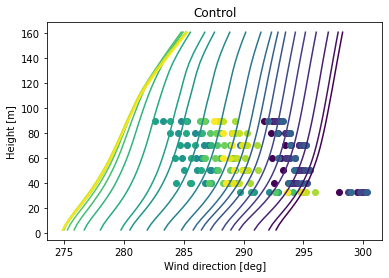

In [57]:
# Wind direction



f, ax = plot_timecolor_v_prof_h_avg( vname = 'wdir', obs_vc = 'dir_levels', \
                                    ds_WRF = ds_10min_control, \
                                    ds_OBS = ds_obs, \
                                    i = i_dmin, j = j_dmin, \
                                    wrf_lab = 'Control')
ax.set_xlabel('Wind direction [deg]')
plt.savefig( save_fig_dir + 'vprof_wdir_timecolor_Control.png', dpi = 300)

#sys.exit()

/g/g12/lassman1/anaconda3/envs/wildfire/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/g12/lassman1/anaconda3/envs/wildfire/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Not saving, save_str not provided


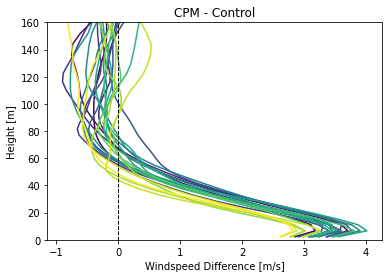

In [70]:

f, ax = plot_timecolor_v_prof_diff_h_avg( ds_10min_cpm, ds_10min_control, i = i_dmin, j = j_dmin, \
                                    wrf_lab = 'CPM - Control')

zero_line_x = np.zeros(101)
zero_line_y = np.linspace(0, 180, 101)

ax.plot( zero_line_x, zero_line_y, 'k--', linewidth = 1.0)
ax.set_ylim([0., 160.])
plt.savefig( save_fig_dir + 'vprof_wspd_timecolor_diff.png', dpi = 300)

/g/g12/lassman1/anaconda3/envs/wildfire/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/g12/lassman1/anaconda3/envs/wildfire/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Not saving, save_str not provided


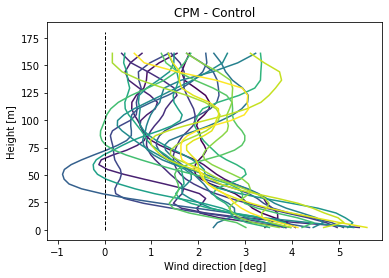

In [71]:

f, ax = plot_timecolor_v_prof_diff_h_avg( ds_10min_cpm, ds_10min_control, \
                                    vname = 'wdir',
                                    i = i_dmin, j = j_dmin, \
                                    wrf_lab = 'CPM - Control')
zero_line_x = np.zeros(101)
zero_line_y = np.linspace(0, 180, 101)
ax.plot( zero_line_x, zero_line_y, 'k--', linewidth = 1.0)


ax.set_xlabel('Wind direction [deg]')
plt.savefig( save_fig_dir + 'vprof_wdir_timecolor_diff.png', dpi = 300)


### Spatial plots

In [44]:
# Get i/j coordinates of FINO-1 tower
ii, jj = np.where( distances == distances.min() )
ii = ii[0]
jj = jj[0]

#Windspeed to get number of grid cells for area plot
Uavg = np.nanmean( ds_10min_cpm.u.values[:25,:,:,:] )
Vavg = np.nanmean( ds_10min_cpm.v.values[:25,:,:,:] )
print(Uavg, Vavg)

12.844188 -4.456597


In [45]:
# NOS array for building array of vertical profile locations

NOS = np.linspace( -30, 12, 8 )
#print(NOS)
# extract vertical profiles

ii_arr = []
jj_arr = []

for n in NOS:
    ii_arr.append( int(ii + Vavg * n) )
    jj_arr.append( int(jj + Uavg * n) )
print(ii_arr, jj_arr)

[358, 331, 305, 278, 251, 225, 198, 171] [35, 112, 189, 266, 343, 421, 498, 575]


99.48278


/g/g12/lassman1/mmc/local_code/Vertical_Profile_Functions.py:283: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolor( ds.x, ds.y, var_inst, vmin=cb_vmin, vmax = cb_vmax )


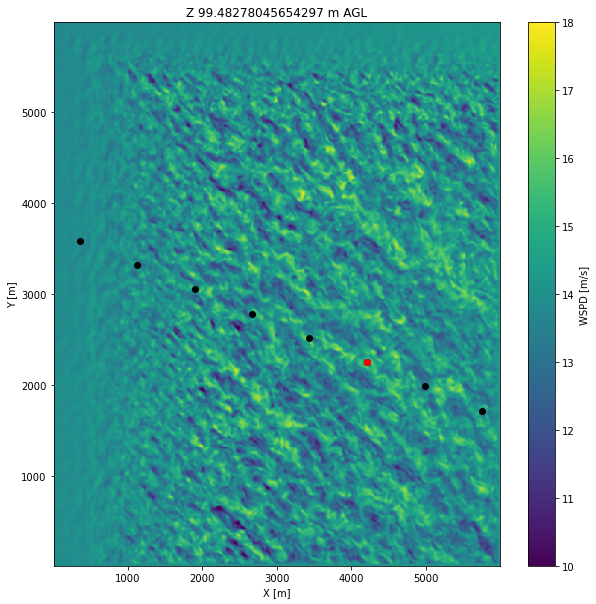

In [46]:



f, ax, pc = plan_view_pcolor( ds_cpm, \
                     scatter_x_arr = jj_arr, scatter_y_arr = ii_arr, \
                     scatter_x_sp = jj, scatter_y_sp = ii )

plt.savefig( save_fig_dir + 'plan_view_pcolor_cpm_example.png', dpi = 300)
                     

Not saving, save_str not provided


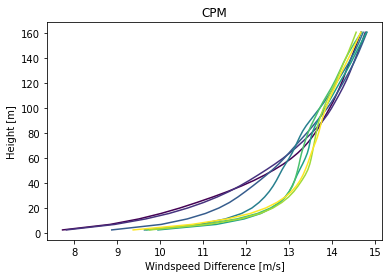

In [47]:


f,ax = plot_spacecolor_v_prof_h_avg( ds_10min_cpm, ii_arr, jj_arr, wrf_lab = 'CPM' )
plt.savefig( save_fig_dir + 'vprof_spacecolor_CPM.png', dpi = 300)                                  

Not saving, save_str not provided


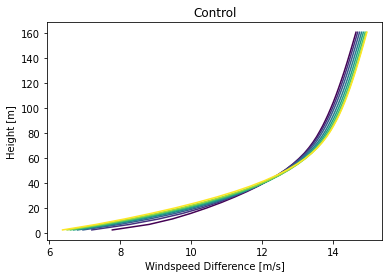

In [48]:


f,ax = plot_spacecolor_v_prof_h_avg( ds_10min_control, ii_arr, jj_arr, wrf_lab = 'Control' )
plt.savefig( save_fig_dir + 'vprof_spacecolor_Control.png', dpi = 300)                                                                    

Not saving, save_str not provided


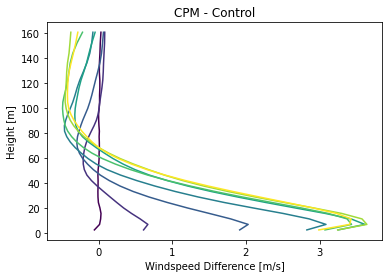

In [49]:


f,ax = plot_spacecolor_v_prof_diff_h_avg( ds_10min_cpm, ds_10min_control, ii_arr, jj_arr, wrf_lab = 'CPM - Control' )
plt.savefig( save_fig_dir + 'vprof_spacecolor_Diff.png', dpi = 300)                                                                                                      

# Compare to observations
### Compute error and bias at each level.<br>
Define vertical windshear as follows:<br>
$Integrated Shear = (z_{top} - z_{bottom})\sum_{i=2}^{N_{obs}}\frac{U(z_{i}) - U(z_{i-1})}{z_{i} - z_{i-1}}$<br>
$Bulk Shear = \frac{U(z_{top}) - U(z_{bottom})}{z_{top} - z_{bottom}}$<br>


In [50]:
# First, interpolate the model windspeeds to the observed levels
from scipy.interpolate import interp1d

NT = len(ds_10min_cpm.datetime.values)
Nspdlevs = len(ds_obs.spd_levels.values)

wspd_cpm_interp = np.empty( [Nspdlevs, NT])
wspd_control_interp = np.empty( [Nspdlevs, NT] )
wspd_obs = np.empty( [Nspdlevs, NT] )

for ti in range(0, NT):
    finterp_CPM = interp1d( ds_10min_cpm.z1D.isel(datetime = ti).values, \
                            ds_10min_cpm.wspd.isel(nx = slice(jj-5,jj+5), ny = slice(ii-5,ii+5), \
                            datetime = ti).mean(dim = ['nx', 'ny']).values )
    finterp_CONTROL = interp1d( ds_10min_control.z1D.isel(datetime = ti).values, \
                            ds_10min_control.wspd.isel(nx = slice(jj-5,jj+5), ny = slice(ii-5,ii+5), \
                            datetime = ti).mean(dim = ['nx', 'ny']).values )
    
    wspd_cpm_interp[:,ti] = finterp_CPM( ds_obs.spd_levels.values )
    wspd_control_interp[:,ti] = finterp_CONTROL( ds_obs.spd_levels.values )
    wspd_obs[:,ti] = ds_obs.wspd.isel( datetime = ti ).values
    print(f"{ti} of {NT}")
    

/g/g12/lassman1/anaconda3/envs/wildfire/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/g12/lassman1/anaconda3/envs/wildfire/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/g12/lassman1/anaconda3/envs/wildfire/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [51]:
#Calculate bulk shear

BS_OBS = np.empty(NT)
BS_CPM = np.empty(NT)
BS_CONTROL =  np.empty(NT)

IS_OBS = np.empty(NT)
IS_CPM = np.empty(NT)
IS_CONTROL =  np.empty(NT)

for ti in range(0,NT):
    BS_OBS[ti] = bulk_shear( ds_obs.spd_levels, wspd_obs[:,ti])
    BS_CPM[ti] = bulk_shear( ds_obs.spd_levels, wspd_cpm_interp[:,ti])
    BS_CONTROL[ti] = bulk_shear( ds_obs.spd_levels, wspd_control_interp[:,ti])
    
    IS_OBS[ti] = integrated_shear( ds_obs.spd_levels, wspd_obs[:,ti])
    IS_CPM[ti] = integrated_shear( ds_obs.spd_levels, wspd_cpm_interp[:,ti])
    IS_CONTROL[ti] = integrated_shear( ds_obs.spd_levels, wspd_control_interp[:,ti])

In [52]:
import pandas as pd
t_obs = pd.to_datetime( ds_10min_cpm.datetime.values )
z_obs = ds_obs.spd_levels

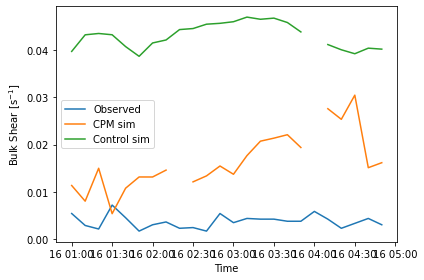

In [53]:
f, ax = plt.subplots()
ax.plot( t_obs, BS_OBS, label = 'Observed')
ax.plot( t_obs, BS_CPM, label = 'CPM sim')
ax.plot( t_obs, BS_CONTROL, label = 'Control sim')

ax.set_ylabel('Bulk Shear [s$^{-1}$]')
ax.set_xlabel('Time')
ax.legend(loc = 'best')

plt.tight_layout()


plt.savefig( save_fig_dir + 'Bulk_Shear.png', dpi = 300)                                                                    

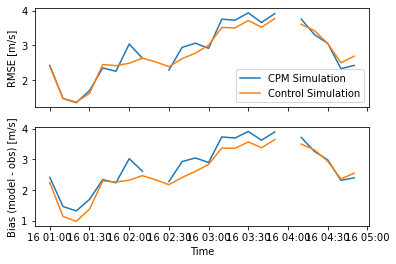

In [54]:
NZobs = len(z_obs)

vRMSE_CPM     = np.sqrt( ( ( wspd_obs - wspd_cpm_interp )**2. ).sum(0) / NZobs )
vRMSE_CONTROL = np.sqrt( ( ( wspd_obs - wspd_control_interp )**2. ).sum(0) / NZobs )

vBIAS_CPM     = np.mean( wspd_cpm_interp - wspd_obs, axis = 0 )
vBIAS_CONTROL = np.mean( wspd_control_interp - wspd_obs, axis = 0 )

f, (ax1, ax2) = plt.subplots( nrows = 2, ncols = 1, sharex = True)
ax1.plot( t_obs, vRMSE_CPM, label = 'CPM Simulation')
ax1.plot( t_obs, vRMSE_CONTROL, label = 'Control Simulation')

ax1.legend(loc = 'best')

ax2.plot( t_obs, vBIAS_CPM, label = 'CPM Simulation')
ax2.plot( t_obs, vBIAS_CONTROL, label = 'Control Simulation')

ax1.set_ylabel('RMSE [m/s]')
ax2.set_ylabel('Bias (model - obs) [m/s]')

ax2.set_xlabel('Time')

plt.savefig( save_fig_dir + 'Error_Bias_vert.png', dpi = 300)      

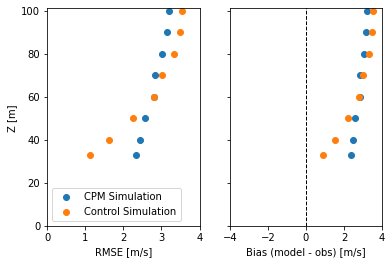

In [69]:
NTobs = len(t_obs)
hRMSE_CPM     = np.sqrt( ( np.nansum(( wspd_obs - wspd_cpm_interp )**2., axis=1 ) / NTobs ) )
hRMSE_CONTROL = np.sqrt( ( np.nansum(( wspd_obs - wspd_control_interp )**2., axis = 1 ) / NTobs ) )

hBIAS_CPM     = np.nanmean( wspd_cpm_interp - wspd_obs, axis = 1 )
hBIAS_CONTROL = np.nanmean( wspd_control_interp - wspd_obs, axis = 1 )

#print(hBIAS_CPM, hRMSE_CPM)

f, (ax1, ax2) = plt.subplots( nrows = 1, ncols = 2, sharey = True)
ax1.scatter( hRMSE_CPM, z_obs, label = 'CPM Simulation')
ax1.scatter( hRMSE_CONTROL, z_obs, label = 'Control Simulation')

ax1.legend(loc = 'best')

ax2.scatter( hBIAS_CPM, z_obs, label = 'CPM Simulation')
ax2.scatter( hBIAS_CONTROL, z_obs, label = 'Control Simulation')

ax1.set_xlabel('RMSE [m/s]')
ax2.set_xlabel('Bias (model - obs) [m/s]')

ax1.set_xlim([0., 4.])
ax2.set_xlim([-4., 4.])
ax1.set_ylim([0., 101.])

zero_line_x = np.zeros( [101] )
zero_line_y = np.linspace(0, 120, 101)
ax2.plot( zero_line_x, zero_line_y, 'k--', linewidth = 1.0 )

ax1.set_ylabel('Z [m]')
plt.savefig( save_fig_dir + 'Error_Bias_horizontal.png', dpi = 300)      